In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer
from timeit import default_timer as timer

### Helper functions for heuristic 1 ###

# alternating maximization oracle
def altmax(r, p, gamma, tol, cmax, c, the_q, Un):
    the = the_q.copy()
    cum_r = np.insert(np.cumsum(r), 0, 0)
    un = Un.shape[0]

    last_cmax = cmax - 1e6
    cnt = 0
    while (True):
        cnt += 1
        the[cum_r[2]:cum_r[3]] = 0
        the[cum_r[2]+np.random.randint(0, 3)] = 1
        for ind in range(p-1):
            pro = c.copy()
            for k in range(p):
                if (ind != k):
                    mask = (the[cum_r[k] + Un[:,k]] == 0)
                    pro[mask] = 0 

            fpro = np.zeros(r[ind])
            for i in range(r[ind]):
                if ind == 0:
                    idx = np.arange(i*600, (i+1)*600)
                    fpro[i] += pro[idx].sum()
                elif ind == 1:
                    idx = np.repeat(np.arange(0, 300) * 600, 3) + np.tile(np.arange(i*3, (i+1)*3), 300)
                    fpro[i] += pro[idx].sum()
                else:
                    idx = np.arange(60000) * 3 + i
                    fpro[i] += pro[idx].sum()

            mask = (fpro >= np.sort(fpro)[r[ind] - gamma[ind]])
            the[cum_r[ind]:cum_r[ind+1]] = (mask).astype(int)
            curr_cmax = np.sum(fpro[mask])

        if (curr_cmax < last_cmax + tol):
            break
        else:
            last_cmax = curr_cmax

    psi = np.ones(un)
    for k in range(p):
        psi = np.multiply(psi, the[cum_r[k] + Un[:,k]])

    return(psi, the, curr_cmax)

### Helper functions for heuristic 2 ###

def place_block(rows, cols, c, p_t, block_shape):
    """
    Put a "block" of 1's in a zero tensor at the same position of the minimal positive entry in the region of p_t defined by rows and cols
    ---
    Arguments:
    rows (sequence[int]): row indices of the left and right boundaries of the region
    cols (sequence[int]): column indices of the left and right boundaries of the region
    c (int): the channel index
    p_t (int): the tensor
    block_shape: the shape of the block

    Returns:
    q_t: the zero tensor that contains a block of 1's
    mu_t (scalar): the value of the minimal positive entry
    mu_t_idx (tuple(int)): the index of the minimal positive entry
    """
    if not isinstance(block_shape, np.ndarray):
        block_shape = np.array(block_shape)

    # find the region    
    region = p_t[..., c].copy() # c-th channel
    region[region <= 0] = np.inf # for finding the minimal positive entry easily
    region = region[rows[0]:rows[1], cols[0]:cols[1]]
    
    # find the value and index of the minimal positive entry 
    mu_t_idx = np.unravel_index(np.argmin(region), region.shape)
    mu_t = region[mu_t_idx]
    if np.isinf(mu_t):
        mu_t = 0
    mu_t_idx = (mu_t_idx[0] + rows[0], mu_t_idx[1] + cols[0], c)

    # place the "block" in the zero tensor
    left = block_shape // 2
    right = block_shape - left
    q_t = np.zeros(p_t.shape)
    q_t[mu_t_idx[0] - left[0]: mu_t_idx[0] + right[0], mu_t_idx[1] - left[1]: mu_t_idx[1] + right[1], c] = 1

    return q_t, mu_t, mu_t_idx

def recover_channel(p_0, block_shape, c, min_n_pix, lpar, verbose=False):
    """
    Reconstruct the c-th channel of the mosaic image p_9
    ---
    Arguments:
    p_0 (np.array): the mosaic image
    block_shape (sequence[scalar]): the shape of the block
    c (int): the channel index
    min_n_pix (int): the minimal number of pixels in a considered region 
    lpars (sequence[scalar]): the lambda parameters for each channel

    Returns:
    Psi_t (np.array): the recovered channel
    mu (list[scalar]): a list of mu_t
    q (list[np.array]): a list of q_t
    """
    r = p_0.shape
    P_t = p_0
    N_t = 0
    Psi_t = np.zeros(r)
    mu = []
    q = []

    row_boundary = [0, r[0]]
    col_boundary = [0, r[1]]

    while True:
        if verbose:
            print(f'N_t is {N_t}')

        num_boundary = len(row_boundary)

        # place a "block" in each region
        for i in range(num_boundary-1):
            for j in range(num_boundary-1):

                # stop when a region is too small
                if (row_boundary[i+1] - row_boundary[i]) * (col_boundary[j+1] - col_boundary[j]) <= min_n_pix:
                    return Psi_t, mu, q
                
                # place a block in the region 
                q_t, mu_t, mu_t_idx = place_block((row_boundary[i], row_boundary[i+1]), (col_boundary[j], col_boundary[j+1]), c, P_t, block_shape)

                # guarantee the gauge norm constraint
                if N_t + mu_t > lpar:
                    return Psi_t, mu, q
                else:
                    N_t = N_t + mu_t
                    Psi_t = Psi_t + mu_t * q_t
                    P_t = P_t - mu_t * q_t # FIX ME
                    mu.append(mu_t)
                    q.append(q_t)      
        
        # bisect each region
        for k in range(1, num_boundary):
            row_boundary.append(row_boundary[k-1] + (row_boundary[k] - row_boundary[k-1]) // 2)
            col_boundary.append(col_boundary[k-1] + (col_boundary[k] - col_boundary[k-1]) // 2)
        
        row_boundary.sort()
        col_boundary.sort()

def heuristic_1(p_0, gamma, lpar=1, tol=1e-4, verbose=False):
    """
    Deflate/decompose the tensor p_0 of the mosaic image
    ---
    Arguments:
    p_0 (np.array): the mosaic image
    gamma (list[scalar]): the l1 norm upper constraint on every theta
    lpar (scalar): the lambda parameter
    tol (scalar): the tolarance used in the alternating maximization

    Returns:
    psi_t (np.array): the flatten version
    Psi_t (np.array): the original version
    mu (list[scalar]): a list of mu_t
    q (list[np.array]): a list of q_t
    """

    # initializing parameters
    r = p_0.shape
    p = len(r)
    cmax = -float('inf')
    Un = np.arange(np.prod(r)) 
    Un = np.unravel_index(Un, r)
    Un = np.vstack(Un).T
    p_t = p_0.flatten()
    un = len(Un)
    N_t = 0
    psi_t = np.zeros(un)
    mu = []
    q = []

    # the deflation algorithm
    while True:
        if verbose:
            print(f'N_t is {N_t}')
        the = np.round(np.random.uniform(0,1,np.sum(r)))
        q_t, _, _ = altmax(r, p, gamma, tol, cmax, p_t, the, Un)
        mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])

        if (N_t + mu_t > lpar):
            break      
        
        N_t = N_t + mu_t
        psi_t = psi_t + mu_t * q_t
        p_t = p_t - mu_t * q_t
        q.append(q_t)
        mu.append(mu_t)

        if p_t.sum() == 0:
            break

    # recover the original shape
    Psi_t = psi_t.reshape(r)

    return psi_t, Psi_t, mu, q


def heuristic_2(p_0, block_shape, min_n_pix, lpars, verbose=False):
    """
    Deflate/decompose the tensor p_0 of the mosaic image
    ---
    Arguments:
    p_0 (np.array): the mosaic image
    block_shape (sequence[scalar]): the shape of the block
    min_n_pix (int): the minimal number of pixels in a considered region 
    lpars (sequence[scalar]): the lambda parameters for each channel

    Returns:
    Psi (np.array): the recovered image
    mu (list[scalar]): a list of mu_t
    q (list[np.array]): a list of q_t
    """
    Psi = np.zeros(p_0.shape)
    mu = []
    q = []

    # recover each color channel separately
    for c in range(3):
        Psi_c, mu_c, q_c = recover_channel(p_0, block_shape, c, min_n_pix, lpars[c], verbose)
        Psi = Psi + Psi_c
        mu.extend(mu_c)
        q.extend(q_c)
    
    return Psi, mu, q

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_6044\1027953272.py:194: RuntimeWarning: divide by zero encountered in true_divide
  mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])
C:\Users\Wenhao\AppData\Local\Temp\ipykernel_6044\1027953272.py:194: RuntimeWarning: invalid value encountered in true_divide
  mu_t = np.min((p_t / q_t)[(p_t > 0) & (q_t > 0)])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Heuristic 1: Sum of mu is 99.94509940454736. Store 1059 vertices. Run time is 61.08848359998956
Heuristic 2: Sum of mu is 3183.494187617209. Store 16383 vertices. Run time is 38.5483738000039


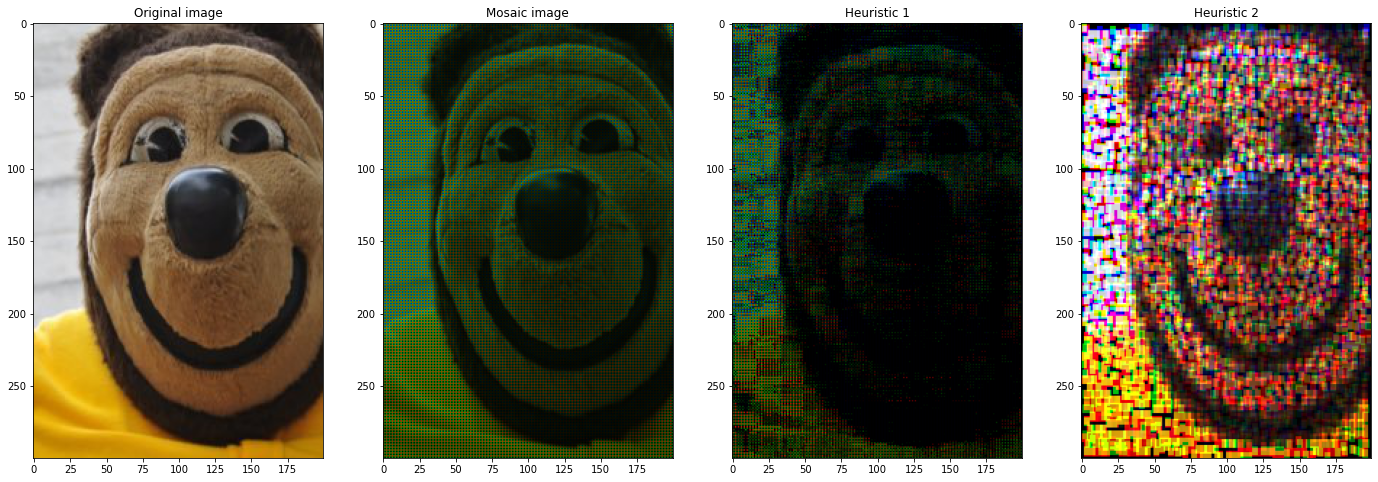

In [4]:
shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

lpar1 = 100
lpar2 = 5000

start_1 = timer()
_, Psi_1, mu_1, q_1 = heuristic_1(mosaic_image, [12, 8, 1], lpar=lpar1, tol=1e-2, verbose=False)
end_1 = timer()

start_2 = timer()
Psi_2, mu_2, q_2 = heuristic_2(mosaic_image, [6, 4], 5, [lpar2/3, lpar2/3, lpar2/3], verbose=False)
end_2 = timer()

print(f'Heuristic 1: Sum of mu is {sum(mu_1)}. Store {len(q_1)} vertices. Run time is {end_1 - start_1}')
print(f'Heuristic 2: Sum of mu is {sum(mu_2)}. Store {len(q_2)} vertices. Run time is {end_2 - start_2}')

fig, axes = plt.subplots(1, 4, figsize=(24, 8))
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
axes[2].imshow(Psi_1)
axes[3].imshow(Psi_2)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('Heuristic 1')
axes[3].set_title('Heuristic 2')
fig.savefig('comparison.png')


**Observation:**

1. When `lpar` in `heuristic_1` is very large, the function cannot terminate correctly.
2. Some entries of `Psi_2` have values larger than 1.
3. There will be a memory issue for `heuristic_2` if `min_n_pix` is too small. So I think if we are working on a larger image, `min_n_pix` needs to be larger.